# **Comment Toxicity Model**

In [1]:
# importing libraries

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer

2024-09-17 16:28:09.512800: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-17 16:28:09.512866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-17 16:28:09.565876: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-17 16:28:09.680180: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-17 16:28:11.764175: W tensorflow/compiler/tf2

In [2]:
# reading data

df = pd.read_csv('train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
# checking for shape of dataset, null values and duplicates 

print(df.shape)
print('-----------------------')
print(df.isnull().sum())
print('-----------------------')
df.duplicated().sum()

(159571, 8)
-----------------------
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
-----------------------


0

In [4]:
df['comment_text'][1]

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

In [5]:
df['comment_text'].iloc[3]

'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

In [6]:
df[df.columns[2:]].iloc[3]

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 3, dtype: int64

In [63]:
# plot_dict = {'Toxic': len(df[df['toxic']==1]), 
#              'severe_toxic': len(df[df['severe_toxic']==1]),
#              'obscene': len(df[df['obscene']==1]),
#              'threat': len(df[df['threat']==1]),
#              'insult': len(df[df['insult']==1]),
#              'identity_hate': len(df[df['identity_hate']==1])}

columns_to_plot = df.columns[2:]
values = []
for col in columns_to_plot:
    values.append(len(df[df[col]==1])/len(df)*100)


In [81]:
sorted_data = sorted(zip(columns_to_plot, values), key= lambda x:x[1], reverse=True)

In [82]:
sorted_categories, sorted_values = zip(*sorted_data)

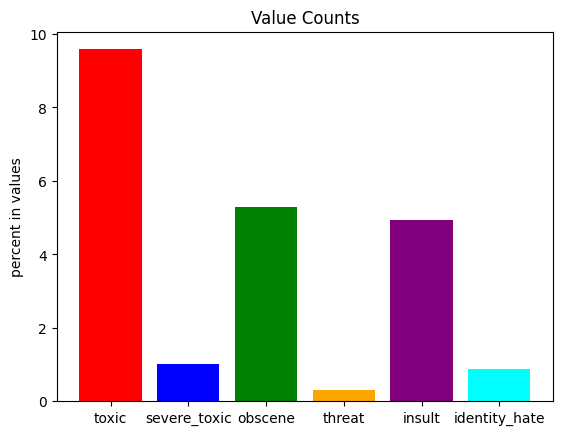

In [83]:
# print(columns_to_plot)
# values
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
plt.bar(columns_to_plot, values, color=colors)
plt.ylabel('percent in values')
plt.title('Value Counts')
plt.show()

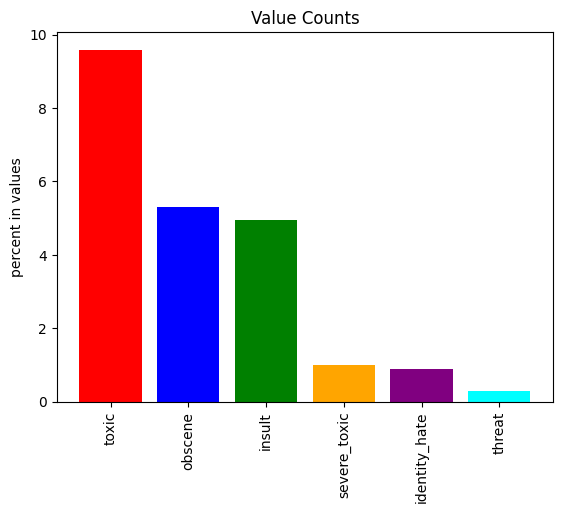

In [90]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
plt.bar(sorted_categories, sorted_values, color=colors)
plt.ylabel('percent in values')
plt.xticks(rotation=90)
plt.title('Value Counts')
plt.show()

## Preprocessing

In [7]:
def preprocess(q):
    
    q = str(q).lower().strip()

    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    q = q.replace('?', '')

    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[UNK]', '')

    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)

     # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "abt": "about",
    "can't": "can not",
    "can't've": "can not have",
    "cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "d' aww": "aww",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have",
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")

        # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()

    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    return q

In [8]:
ps = PorterStemmer()

def stem_words(text):
    return " ".join([ps.stem(word) for word in text.split()])

In [9]:
df['comment_text'] = df['comment_text'].apply(preprocess)

/tmp/ipykernel_225696/1544314195.py:164: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  q = BeautifulSoup(q)
/tmp/ipykernel_225696/1544314195.py:164: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  q = BeautifulSoup(q)


In [10]:
# df['comment_text'].apply(stem_words)

In [11]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d aww he matches this background colour i am ...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i am really not trying to edit war i...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i can not make any real suggestions on im...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0,0,0,0,0,0


In [12]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [13]:
MAX_FEATURES = 200000

In [14]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES, 
                               output_sequence_length=1800,
                               output_mode='int')

2024-09-17 16:28:30.189329: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-17 16:28:30.391539: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-17 16:28:30.391615: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-17 16:28:30.394880: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-17 16:28:30.394955: I external/local_xla/xla/stream_executor

In [15]:
vectorizer.adapt(X.values)

In [16]:
vectorizer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'to',
 'i',
 'of',
 'and',
 'you',
 'a',
 'is',
 'that',
 'not',
 'it',
 'in',
 'for',
 'this',
 'on',
 'have',
 'are',
 'be',
 'as',
 'your',
 'do',
 'with',
 'if',
 'article',
 'was',
 'or',
 'but',
 'wikipedia',
 'page',
 'my',
 'an',
 'from',
 'by',
 'at',
 's',
 'will',
 'can',
 'me',
 'about',
 'talk',
 'so',
 'would',
 'am',
 'what',
 'there',
 'all',
 'has',
 'please',
 'no',
 'they',
 'he',
 'one',
 'like',
 'just',
 'we',
 'which',
 'should',
 'any',
 'been',
 'more',
 'some',
 'other',
 'here',
 'who',
 'see',
 'also',
 'his',
 'because',
 'did',
 'think',
 'know',
 'how',
 'people',
 'does',
 'edit',
 'why',
 'up',
 'only',
 'out',
 'articles',
 'when',
 'use',
 'then',
 'time',
 'were',
 'may',
 'them',
 'now',
 'being',
 'their',
 'user',
 'than',
 'thanks',
 'even',
 'get',
 'make',
 'could',
 'good',
 'had',
 'well',
 'very',
 'information',
 'want',
 'its',
 'such',
 'deletion',
 'sources',
 'way',
 'name',
 'image',
 'these',
 'first',
 'wp',
 

In [17]:
vectorized_text = vectorizer(X.values)

2024-09-17 16:28:46.313570: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-09-17 16:28:46.765542: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2297822400 exceeds 10% of free system memory.


In [18]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  671,    77,     2, ...,     0,     0,     0],
       [  469, 16795,    52, ...,     0,     0,     0],
       [  401,   412,     4, ...,     0,     0,     0],
       ...,
       [29316,  7256,  5139, ...,     0,     0,     0],
       [    6,    12,   559, ...,     0,     0,     0],
       [    6,     4,   133, ...,     0,     0,     0]])>

In [19]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(32)
dataset = dataset.prefetch(8)

In [20]:
batch_X, batch_y = dataset.as_numpy_iterator().next()

2024-09-17 16:28:47.399015: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2297822400 exceeds 10% of free system memory.


In [21]:
data_len = len(dataset)

In [22]:
train = dataset.take(int(data_len*0.7))
val = dataset.skip(int(data_len*0.7)).take(int(data_len*0.2))
test = dataset.skip(int(data_len*9)).take(int(data_len*0.1))

In [23]:
train_generator = train.as_numpy_iterator()

2024-09-17 16:28:48.282316: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2297822400 exceeds 10% of free system memory.


## Create Sequential Model

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Embedding

In [25]:
model = Sequential()

model.add(Embedding(MAX_FEATURES+1, 100))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='sigmoid'))


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         20000100  
                                                                 
 bidirectional (Bidirection  (None, 64)                34048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [27]:
model.compile(optimizer='Adam', loss='BinaryCrossentropy', metrics=['accuracy'])

In [28]:
hist = model.fit(train, epochs=2, validation_data=val)

Epoch 1/2


2024-09-17 16:28:51.686266: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-09-17 16:28:52.236324: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f2be8888070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-17 16:28:52.236389: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-09-17 16:28:52.257070: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1726570732.367719  225961 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6981/6981 [==============================] - ETA: 0s - loss: 0.0602 - accuracy: 0.9813

2024-09-17 16:48:33.189134: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2297822400 exceeds 10% of free system memory.


6981/6981 [==============================] - 1350s 193ms/step - loss: 0.0602 - accuracy: 0.9813 - val_loss: 0.0437 - val_accuracy: 0.9944
Epoch 2/2
6981/6981 [==============================] - 1304s 187ms/step - loss: 0.0437 - accuracy: 0.9941 - val_loss: 0.0378 - val_accuracy: 0.9940


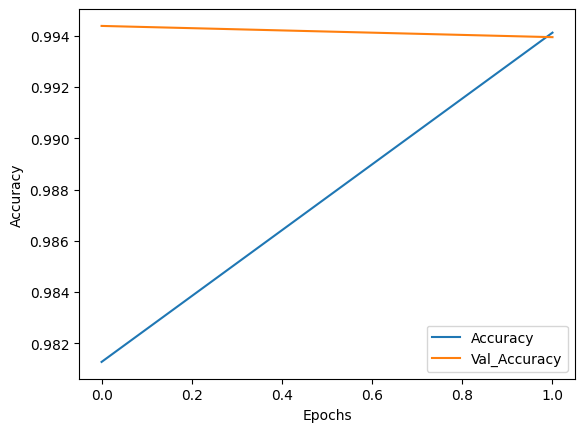

In [29]:
plt.plot(hist.history['accuracy'], label='Accuracy')
plt.plot(hist.history['val_accuracy'], label='Val_Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

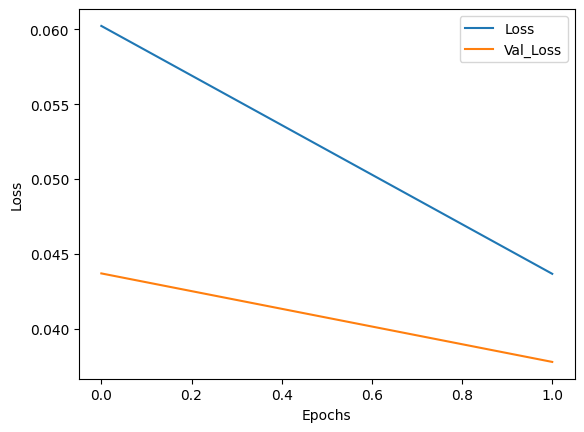

In [30]:
plt.plot(hist.history['loss'], label='Loss')
plt.plot(hist.history['val_loss'], label='Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [43]:
input_text = vectorizer(preprocess("You are a most idiot person I have ever seen"))

In [44]:
model.predict(np.expand_dims(input_text, 0))

1/1 [==============================] - 0s 155ms/step


array([[0.9472195 , 0.08517633, 0.61316144, 0.03385827, 0.6182931 ,
        0.09844922]], dtype=float32)

In [36]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [91]:
model.save('toxic.h5')

/home/yash/anaconda3/envs/py10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
